# Coupon redemption - POC

**Summary:**
1. Introduction
    - 1.1. Context
    - 1.2. Problem statement
    - 1.3. Reading Data
    - 1.4. Data description
2. Individual table analyse
    - 2.1. Customer demographics
    - 2.2. Campaign data
    - 2.3. Customer transaction 
    - 2.4. Item data
3. Table merging according to schema
    1. Merge Coupon data and item data by item_id
    2. Aggregate transactions(mean and sum) by item_id and merge both mean and sum
    3. Merge step 1 and 2 on item_id
    4. Aggregate step 3 by 'coupon_id' 
    5. Aggregate transactions(mean and sum) by customer_id and merge both mean and sum
    6. Merge all to the train and test data
4. Exploratory data analysis
    - Successful campaign 
    - Campaign duration
5. Label Encoding
6. Missing values Imputation
7. Class balance
8. Feature scaling - Normalization
9. Data split - Train test split
10. Model building [Decision tree, Random forest, KNN] and Data validation [Cross validation]  
11. Model performance score - Confusion matrix


# 1. Introduction

**1.1. Context:**

XYZ Credit Card company regularly helps it’s merchants understand their data better and take key business decisions accurately by providing machine learning and analytics consulting. ABC is an established Brick & Mortar retailer that frequently conducts marketing campaigns for its diverse product range. As a merchant of XYZ, they have sought XYZ to assist them in their discount marketing process using the power of machine learning. Can you wear the AmExpert hat and help out ABC?
Discount marketing and coupon usage are very widely used promotional techniques to attract new customers and to retain & reinforce loyalty of existing customers. The measurement of a consumer’s propensity towards coupon usage and the prediction of the redemption behaviour are crucial parameters in assessing the effectiveness of a marketing campaign.
ABC’s promotions are shared across various channels including email, notifications, etc. A number of these campaigns include coupon discounts that are offered for a specific product/range of products. The retailer would like the ability to predict whether customers redeem the coupons received across channels, which will enable the retailer’s marketing team to accurately design coupon construct, and develop more precise and targeted marketing strategies.


**1.2. Problem statement:**
    - Find which campaign performed better based on the coupon redemption
    - Find the probability score of coupon redemption


In [1]:
#Data Preprocessing
import pandas as pd
import numpy as np
from statistics import mode 

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")


#Data Encoding
from sklearn.preprocessing import LabelEncoder

#classification Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#Importing metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 1.3. Reading Data

In [2]:
#Reading files
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')
campaign = pd.read_csv('campaign_data.csv', sep=',')
coupon = pd.read_csv('coupon_item_mapping.csv', sep=',')
demographics = pd.read_csv('customer_demographics.csv', sep=',')
transaction = pd.read_csv('customer_transaction_data.csv', sep=',')
item = pd.read_csv('item_data.csv', sep=',')


### 1.3. Dataset Description

In [3]:
#Checking the shape of all the datasets
print('train : ', train.shape,'\n', train.isnull().sum())
print('======================================')
print('test : ', test.shape,'\n', test.isnull().sum())
print('======================================')
print('campaign : ', campaign.shape,'\n', campaign.isnull().sum())
print('======================================')
print('coupon : ', coupon.shape,'\n', coupon.isnull().sum())
print('======================================')
print('demographics : ', demographics.shape,'\n', demographics.isnull().sum())
print('======================================')
print('transaction : ', transaction.shape,'\n', transaction.isnull().sum())
print('======================================')
print('item : ', item.shape,'\n', item.isnull().sum())
print('======================================')


train :  (78369, 5) 
 id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64
test :  (50226, 4) 
 id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64
campaign :  (28, 4) 
 campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64
coupon :  (92663, 2) 
 coupon_id    0
item_id      0
dtype: int64
demographics :  (760, 7) 
 customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64
transaction :  (1324566, 7) 
 date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64
item :  (74066, 4) 
 item_id       0
brand         0
brand_type    0
category      0
dtype: int64


Observations:
1. Each datasets sizes are differ from each other
2. There are missing values in Customer Demographics data

# 2. Individual table Analyse

### 2.1. Customer demographics 

In [107]:
demographics.head()

customer_id age_range marital_status  rented  family_size  no_of_children  \
0            1       70+        Married       0            2               0   
1            6     46-55        Married       0            2               0   
2            7     26-35        Married       0            3               1   
3            8     26-35        Married       0            4               2   
4           10     46-55         Single       0            1               0   

   income_bracket  
0               4  
1               5  
2               3  
3               6  
4               5

In [5]:
demographics.rented.value_counts()

0    719
1     41
Name: rented, dtype: int64

In [106]:
#Customer demographics missing values
missing_values = (1- demographics.count()/len(demographics)).round(4)*100
pd.DataFrame(missing_values, columns=["%"])

%
customer_id     0.0
age_range       0.0
marital_status  0.0
rented          0.0
family_size     0.0
no_of_children  0.0
income_bracket  0.0

***Note:***

As we know that 30%-40% of missing values are allowed beyond that we might want to drop the features. But however the above missing values can be imputed based on logical reasons. 

For example: If the family size is 1 then obviously that person will be single and there will be no children.
Considering the fact we are going to fill the missing values. 

In [7]:
print(demographics.info())
print('============================================')
print(demographics.family_size.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB
None
2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64


***Note:*** We can clearly see that the column 'family_size' is a object type. So we need to change the data type into 'int' so that it will be easy to impute missing values.

In [8]:
#Checking the number of unique values for marital_status and no_of_children  
print(demographics.marital_status.value_counts())
print('===================================')
print(demographics.no_of_children.value_counts())

Married    317
Single     114
Name: marital_status, dtype: int64
1     107
3+     60
2      55
Name: no_of_children, dtype: int64


In [9]:
import re
#no of children = int64 ... we need to ignore the NaN values while converting to float
demographics['family_size'] = demographics.family_size.apply(lambda x: int(re.sub('\+','',x)))
demographics['no_of_children'] = demographics.no_of_children.apply(lambda x: int(re.sub('\+','',x)) if pd.notna(x) else x)

In [10]:
#Checking if there are any logic error
print("Marital_status mismatch: ", len(demographics[(demographics['family_size']==1) & (demographics['marital_status']=='Married')]))
print("no_of_children mismatch: ", len(demographics[(demographics['family_size']==1) & (demographics['no_of_children']==(1,2,3))]))

Marital_status mismatch:  0
no_of_children mismatch:  0


In [11]:
#If family size is 1 then the person should be single
demographics.loc[(demographics['marital_status'].isnull()) & (demographics['family_size']==1), "marital_status"]='Single'
#If the person have a child then we can consider their marital status as Married
#demographics.loc[(demographics['marital_status'].isnull()) & (demographics['no_of_children']==('1','2','3')), "marital_status"]='Married'

#customers whos family size - no of childrens == 1, will also be single 
#This is applicable where there is only 1 parent --- We treat 1 parent as Single
demographics.loc[(demographics.family_size - demographics.no_of_children == 1) & pd.isnull(demographics.marital_status),'marital_status'] = 'Single'

#from the orignal data we have 186 of 196 customers with diff of 2 in their family size and number of childrens as
#Married (see the below cell) and hence where ever the difference is 2 and marital status is NaN and No of Children is 
#NaN we impute the Marital Status as Married
demographics.loc[(pd.isnull(demographics.marital_status)) & ((demographics.family_size - demographics.no_of_children) == 2) & (pd.notnull(demographics.no_of_children)),'marital_status'] = 'Married'

#original data shows customers with fam size == 2, and NaN in no of childrens are majorly Married (see below cell skipping 1 cell)
demographics.loc[pd.isnull(demographics.marital_status) & (pd.isnull(demographics.no_of_children)) & (demographics.family_size ==2),'marital_status'] = 'Married'

In [12]:
demographics.marital_status.groupby((demographics.family_size - demographics.no_of_children) == 2).value_counts()[True]

marital_status
Married    186
Single      10
Name: marital_status, dtype: int64

In [13]:
#If the person is single then obviosly there will be no child
demographics.loc[(demographics['no_of_children'].isnull()) & (demographics.family_size == 1) & (demographics['marital_status']=='Single'), "no_of_children"]=0

#singles with family size == 2, will probably have 1 child
demographics.loc[pd.isnull(demographics.no_of_children) & (demographics.family_size == 2) & (demographics['marital_status']=='Single'),'no_of_children'] = 1

#married with family size ==2 can have no_of_child as 0.
demographics.loc[(demographics['marital_status']=="Married") & (demographics['family_size']==2) & (demographics['no_of_children'].isnull()), "no_of_children"]=0


demographics.no_of_children=demographics.no_of_children.astype(int)

In [14]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  760 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    int64 
 5   no_of_children  760 non-null    int32 
 6   income_bracket  760 non-null    int64 
dtypes: int32(1), int64(4), object(2)
memory usage: 38.7+ KB


### 2.2. Campaign data

In [15]:
campaign.head()

campaign_id campaign_type start_date  end_date
0           24             Y   21/10/13  20/12/13
1           25             Y   21/10/13  22/11/13
2           20             Y   07/09/13  16/11/13
3           23             Y   08/10/13  15/11/13
4           21             Y   16/09/13  18/10/13

In [16]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [17]:
campaign.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

Observations:
    1. There are only 28 records in campaign dataset
    2. There are 2 types of campaign X and Y
    3. Campain start and end date has been given through which we can calculate duration of the campaign

In [18]:
#Converting date into datetime type
campaign['start_date'] = pd.to_datetime(campaign['start_date'],  format='%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'],  format='%d/%m/%y')

#Encoding Campaign type - Y as 1, X as 0
#Creating a new column campaign_duration
campaign["campaign_duration"] = campaign["end_date"] - campaign["start_date"]
campaign["campaign_duration"] = campaign["campaign_duration"].apply(lambda x: x.days) 

#sort dataframe by campaign date
campaign = campaign.sort_values('start_date').reset_index(drop=True)

In [19]:
campaign.head()

campaign_id campaign_type start_date   end_date  campaign_duration
0           26             X 2012-08-12 2012-09-21                 40
1           27             Y 2012-08-25 2012-10-27                 63
2           28             Y 2012-09-16 2012-11-16                 61
3           29             Y 2012-10-08 2012-11-30                 53
4           30             X 2012-11-19 2013-01-04                 46

### 2.3. Customer Transaction 

In [20]:
transaction.tail()

date  customer_id  item_id  quantity  selling_price  \
1324561  2013-06-30         1129     2777         1         284.60   
1324562  2013-06-30         1129     2953         4          42.74   
1324563  2013-06-30         1129     2971         6          64.12   
1324564  2013-06-30         1129    46984         1          95.82   
1324565  2013-06-30         1129    64498         2         489.78   

         other_discount  coupon_discount  
1324561          -71.24              0.0  
1324562          -28.50              0.0  
1324563          -42.74              0.0  
1324564            0.00              0.0  
1324565            0.00              0.0

In [21]:
transaction.shape

(1324566, 7)

In [22]:
transaction[transaction['coupon_discount']<0].head()

date  customer_id  item_id  quantity  selling_price  \
88   2012-01-02          464     5525         1         106.50   
93   2012-01-02          464     8145         1          39.18   
104  2012-01-02          464    16381         1          48.80   
107  2012-01-02          464    17861         3          75.51   
112  2012-01-02          464    19583         2         124.67   

     other_discount  coupon_discount  
88           -35.62           -35.62  
93           -24.58           -14.25  
104          -14.96           -35.62  
107          -32.06           -26.71  
112          -45.59           -35.62

In [23]:
transaction.other_discount = np.abs(transaction.other_discount)
transaction.coupon_discount = np.abs(transaction.coupon_discount)

In [24]:
len(transaction[(transaction.other_discount==0 )& (transaction.coupon_discount==0)])

645250

In [25]:
transaction.describe()

customer_id       item_id      quantity  selling_price  \
count  1.324566e+06  1.324566e+06  1.324566e+06   1.324566e+06   
mean   8.040020e+02  2.951903e+04  1.306633e+02   1.146036e+02   
std    4.573363e+02  1.790806e+04  1.311545e+03   1.529053e+02   
min    1.000000e+00  1.000000e+00  1.000000e+00   3.600000e-01   
25%    4.180000e+02  1.468400e+04  1.000000e+00   4.916000e+01   
50%    8.010000e+02  2.659700e+04  1.000000e+00   7.801000e+01   
75%    1.198000e+03  4.240575e+04  1.000000e+00   1.243100e+02   
max    1.582000e+03  7.406600e+04  8.963800e+04   1.780964e+04   

       other_discount  coupon_discount  
count    1.324566e+06     1.324566e+06  
mean     1.776871e+01     5.948983e-01  
std      3.788867e+01     7.069367e+00  
min      0.000000e+00     0.000000e+00  
25%      0.000000e+00     0.000000e+00  
50%      1.780000e+00     0.000000e+00  
75%      2.315000e+01     0.000000e+00  
max      3.120310e+03     1.992230e+03

In [26]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [27]:
#Converting Date time into datetime format
transaction['date'] = pd.to_datetime(transaction['date'])
transaction = transaction.sort_values('date').reset_index(drop=True)

#Adding day, month and weekday based on the given date
transaction['day']=pd.DatetimeIndex(transaction['date']).day
transaction['month']=pd.DatetimeIndex(transaction['date']).month
transaction['weekday']=pd.DatetimeIndex(transaction['date']).weekday

In [28]:
#Calculation selling price and discount for single quantity
transaction['selling_price'] = transaction['selling_price'] / transaction['quantity']
transaction['other_discount'] = transaction['other_discount'] / transaction['quantity']
transaction['selling_price'] = transaction['selling_price']-transaction['other_discount']
#Adding new feature to know if coupon was used or not
transaction['coupon_used'] = transaction.coupon_discount.apply(lambda x: 1 if x !=0 else 0)
transaction['Total_discount'] = transaction['coupon_discount']+transaction['other_discount']

In [29]:
def distribution_check(data):    
    fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,4))
    fig.suptitle('Distribution of Transaction')
    sns.boxplot(data.quantity, ax=ax1)
    ax1.set_title('Quantity')
    sns.boxplot(data.selling_price, ax=ax2)
    ax2.set_title('Selling price')
    
    fig1,ax3=plt.subplots(1,1,figsize=(12,4))
    sns.boxplot(data.Total_discount, ax=ax3)
    ax3.set_title('Total discount')
    fig1.tight_layout()
    plt.show()

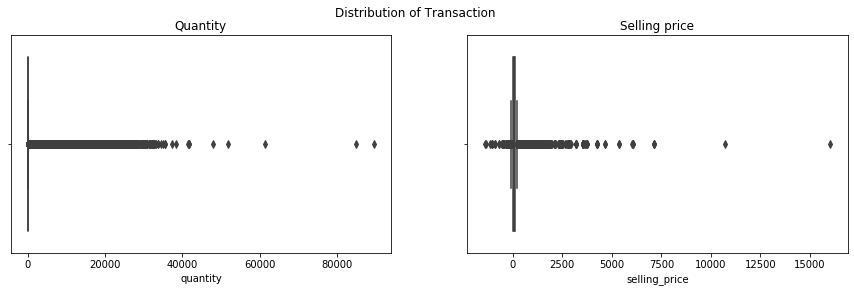

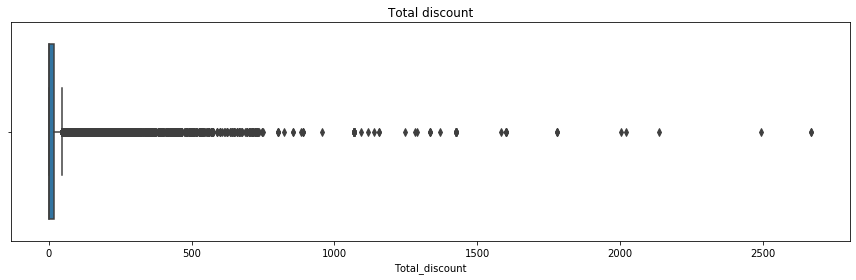

quantity
Mean :  130.6633395391396
Standard Deviation :  1311.5454472232
Value of 3 standard deviation :  4065.2996812087395
Number of data away from 3 standard deviation :  14267
Percentage of data away from 3 standard deviation :  1.0
**********************************************************
selling_price
Mean :  74.14802242455492
Standard Deviation :  91.11477312866484
Value of 3 standard deviation :  347.4923418105494
Number of data away from 3 standard deviation :  21802
Percentage of data away from 3 standard deviation :  2.0
**********************************************************
other_discount
Mean :  13.554292088272899
Standard Deviation :  25.75620532391647
Value of 3 standard deviation :  90.8229080600223
Number of data away from 3 standard deviation :  16276
Percentage of data away from 3 standard deviation :  1.0
**********************************************************
coupon_discount
Mean :  0.5948983214124705
Standard Deviation :  7.069366655490605
Value of 3 stand

In [30]:
#Trying to get 3 standard deviation value of each variable
distribution_check(transaction)
def transaction_check(data):
    tran_mean=data.mean()
    tran_std=data.std()
    std_3 = tran_mean + (3*tran_std)
    tot_len_3_std = len(data[data>std_3])
    per_3_std = tot_len_3_std/len(data)
    print(data.name)
    print('Mean : ', tran_mean)
    print('Standard Deviation : ', tran_std)
    print('Value of 3 standard deviation : ', std_3)
    print('Number of data away from 3 standard deviation : ', tot_len_3_std)
    print('Percentage of data away from 3 standard deviation : ', round(per_3_std,2)*100)
    print('**********************************************************')

transaction_check(transaction['quantity'])    
transaction_check(transaction['selling_price'])
transaction_check(transaction['other_discount'])
transaction_check(transaction['coupon_discount'])

In [31]:
#Removing outlier from total_discount
transaction=transaction[transaction.Total_discount<2000]
#len(transaction)
#distribution_check(transaction)

**Observations:**
    1. There are no null values 
    2. Selling price and discount given for all the quantities and we broke down for each quantity
    3. It seems more number of data of selling price, other disount and coupon discount falls outside 3 standard deviation
    4. Calculated Total discount and removed the outlier

### 2.4. Coupon

### 2.4. Item table

In [32]:
item.tail()

item_id  brand   brand_type        category
74061    74062   5490  Established  Pharmaceutical
74062    74063   5497  Established  Pharmaceutical
74063    74064   5497  Established  Pharmaceutical
74064    74065   5520  Established  Pharmaceutical
74065    74066   5194  Established         Grocery

In [33]:
print(item.brand_type.value_counts())
print("====================================")
print(item.category.value_counts())

Established    62842
Local          11224
Name: brand_type, dtype: int64
Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64


# 3. Table merging 
We merged all the individual data to the train and test data with the above mapping. Below are the steps followed.
    - Step1: coupon_item = Coupon + item mapping on ‘item_id’
    - Step2: Transaction = Transaction1+ Transaction2 [aggregated by ‘item_id’]
    - Step3: Merge Transaction + coupon_item = Transaction_df
    - Step4: Transaction_df aggregated by ‘coupon_id’
    - Step5: Transaction_df2 = Transaction3+ Transaction4 [aggregated by ‘customer_id’]
    - Step6: Merge all data

In [35]:
#Step1
coupon_item = pd.merge(coupon,item, how='left', on='item_id')
coupon_item.head()

coupon_id  item_id  brand   brand_type category
0        105       37     56        Local  Grocery
1        107       75     56        Local  Grocery
2        494       76    209  Established  Grocery
3        522       77    278  Established  Grocery
4        518       77    278  Established  Grocery

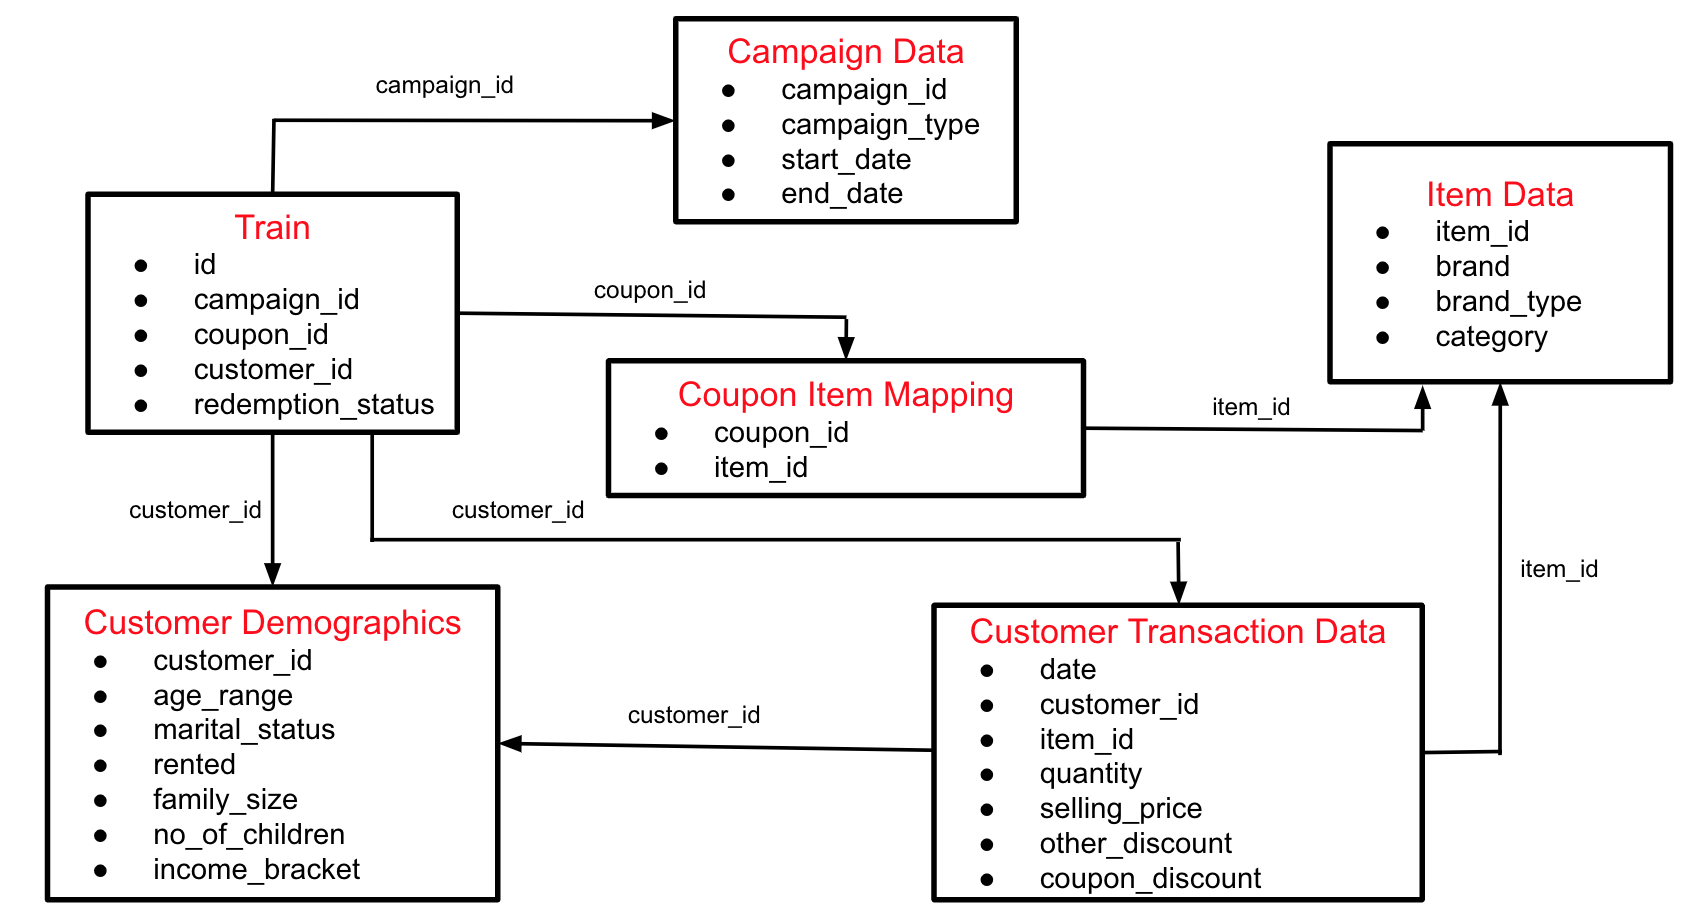

In [34]:
from IPython.display import Image
Image(filename='Schema.png') 

In [36]:
#Step2 - Mean Aggregate
# Aggregate transactions by item_id by mean for a particular customer
transactions1 = pd.pivot_table(transaction, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used', 'Total_discount'],
               aggfunc={'customer_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum,
                        'Total_discount':np.mean} )
transactions1.reset_index(inplace=True)
transactions1.rename(columns={'customer_id': 'no_of_customers', 'selling_price': 'item_price_mean', 
                              'other_discount': 'item_od_mean', 'coupon_discount': 'item_cd_mean', 
                              'quantity': 'item_qu_mean', 'Total_discount':'total_discount_mean'}, inplace=True)
transactions1.head()

item_id  total_discount_mean  item_cd_mean  coupon_used  no_of_customers  \
0        1                  0.0           0.0            0                2   
1        2                  0.0           0.0            0                1   
2        3                  0.0           0.0            0                1   
3        4                  0.0           0.0            0                1   
4        5                  0.0           0.0            0                1   

   item_od_mean  item_qu_mean  item_price_mean  
0           0.0           1.0           124.31  
1           0.0           1.0            35.26  
2           0.0           1.0            56.64  
3           0.0           1.0            54.85  
4           0.0           1.0            81.57

In [37]:
#Step2 - Sum Aggregate
# Aggregate transactions by item_id by sum for a particular customer
transactions2 = pd.pivot_table(transaction, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','Total_discount'],
               aggfunc={'customer_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,
                        'Total_discount':np.sum
                        } )
transactions2.reset_index(inplace=True)
transactions2.rename(columns={'customer_id': 't_counts', 'quantity':'item_qu_sum',
                             'selling_price':'item_price_sum', 'other_discount':'item_od_sum',
                             'coupon_discount':'item_cd_sum', 'Total_discount':'total_discount_sum'}, inplace=True)
transactions2.head()

item_id  total_discount_sum  item_cd_sum  t_counts  item_od_sum  \
0        1                 0.0          0.0         2          0.0   
1        2                 0.0          0.0         1          0.0   
2        3                 0.0          0.0         1          0.0   
3        4                 0.0          0.0         1          0.0   
4        5                 0.0          0.0         1          0.0   

   item_qu_sum  item_price_sum  
0            2          248.62  
1            1           35.26  
2            1           56.64  
3            1           54.85  
4            1           81.57

In [38]:
#Step2 - Merge both transaction 1 and 2
transactions_df = pd.merge(transactions1, transactions2, on="item_id", how='left')
transactions_df.head()

item_id  total_discount_mean  item_cd_mean  coupon_used  no_of_customers  \
0        1                  0.0           0.0            0                2   
1        2                  0.0           0.0            0                1   
2        3                  0.0           0.0            0                1   
3        4                  0.0           0.0            0                1   
4        5                  0.0           0.0            0                1   

   item_od_mean  item_qu_mean  item_price_mean  total_discount_sum  \
0           0.0           1.0           124.31                 0.0   
1           0.0           1.0            35.26                 0.0   
2           0.0           1.0            56.64                 0.0   
3           0.0           1.0            54.85                 0.0   
4           0.0           1.0            81.57                 0.0   

   item_cd_sum  t_counts  item_od_sum  item_qu_sum  item_price_sum  
0          0.0         2          0.0            2          248.62  
1          0.0         1          0.0            1           35.26  
2          0.0         1          0.0            1           56.64  
3          0.0         1          0.0            1           54.85  
4          0.0         1          0.0            1           81.57

In [39]:
transactions_df.item_id[:105]

0        1
1        2
2        3
3        4
4        5
      ... 
100    101
101    102
102    103
103    104
104    105
Name: item_id, Length: 105, dtype: int64

In [40]:
#Step3 -  Merge Aggregated transaction and coupon_item
coup_item_trans = pd.merge(coupon_item, transactions_df, how= 'left', on='item_id')
coup_item_trans.head()

coupon_id  item_id  brand   brand_type category  total_discount_mean  \
0        105       37     56        Local  Grocery             8.108333   
1        107       75     56        Local  Grocery             2.633712   
2        494       76    209  Established  Grocery            17.450000   
3        522       77    278  Established  Grocery            16.920000   
4        518       77    278  Established  Grocery            16.920000   

   item_cd_mean  coupon_used  no_of_customers  item_od_mean  item_qu_mean  \
0           0.0          0.0              2.0      8.108333      2.285714   
1           0.0          0.0              4.0      2.633712      1.363636   
2           0.0          0.0              1.0     17.450000      1.000000   
3           0.0          0.0              2.0     16.920000      1.000000   
4           0.0          0.0              2.0     16.920000      1.000000   

   item_price_mean  total_discount_sum  item_cd_sum  t_counts  item_od_sum  \
0        41.030714           56.758333          0.0       7.0    56.758333   
1        33.561061           86.912500          0.0      33.0    86.912500   
2        71.600000           17.450000          0.0       1.0    17.450000   
3        53.430000           33.840000          0.0       2.0    33.840000   
4        53.430000           33.840000          0.0       2.0    33.840000   

   item_qu_sum  item_price_sum  
0         16.0         287.215  
1         45.0        1107.515  
2          1.0          71.600  
3          2.0         106.860  
4          2.0         106.860

In [41]:
#Step4 - Aggregating coup_item_trans by coupon_id
coupon = pd.pivot_table(coup_item_trans, index ="coupon_id",
                         values=[ 'item_id', 'brand', 'brand_type', 'category',
       'item_cd_mean', 'coupon_used', 'no_of_customers', 'item_od_mean',
       'item_qu_mean', 'item_price_mean', 'item_cd_sum', 't_counts', 'item_od_sum', 'item_qu_sum',
       'item_price_sum', 'total_discount_mean', 'total_discount_sum'],
              aggfunc={'item_id':lambda x: len(set(x)),
                       'brand':lambda x: x.mode().iat[0],
                       'brand_type':lambda x: x.mode().iat[0],
                       'category':lambda x: x.mode().iat[0],
                       'item_cd_mean':np.mean,
                       'no_of_customers':np.mean,
                       'item_od_mean':np.mean,
                       'item_qu_mean':np.mean,
                       'item_price_mean':np.mean,
                       'coupon_used': np.sum,
                       'item_cd_sum': np.sum,
                       't_counts': np.sum,
                       'item_od_sum': np.sum,
                       'item_qu_sum': np.sum,
                       'item_price_sum': np.sum,
                       'total_discount_mean': np.mean,
                       'total_discount_sum': np.sum
                      })
coupon.reset_index(inplace=True)
coupon.rename(columns={'item_id':'item_counts'}, inplace=True)
coupon.head()


coupon_id  brand   brand_type          category  coupon_used  item_cd_mean  \
0          1   1475  Established  Natural Products         35.0      1.321524   
1          2   2084  Established           Grocery          0.0      0.000000   
2          3    278  Established           Grocery         15.0      2.747358   
3          4    544  Established           Grocery         44.0      1.485152   
4          5   5357  Established    Pharmaceutical          0.0      0.000000   

   item_cd_sum  item_counts  item_od_mean   item_od_sum  item_price_mean  \
0      1526.31           39     16.620713  18780.020833        67.941819   
1         0.00            2     21.343885   1163.521667        79.846729   
2       578.81           17     14.728021   4055.343333       102.199851   
3       881.59           24     36.718597  25895.740000       138.271175   
4         0.00            7     27.265786   1228.880000       349.438429   

   item_price_sum  item_qu_mean  item_qu_sum  no_of_customers  t_counts  \
0    52236.826667      1.221644       1034.0        14.794872     826.0   
1     6613.476667      1.137500        103.0        15.000000      81.0   
2    19645.803333      1.121525        248.0         8.588235     212.0   
3    91082.543333      1.020872        702.0        22.333333     676.0   
4    14178.810000      1.000000         44.0         6.000000      44.0   

   total_discount_mean  total_discount_sum  
0            17.942237        20306.330833  
1            21.343885         1163.521667  
2            17.475379         4634.153333  
3            38.203749        26777.330000  
4            27.265786         1228.880000

In [42]:
#Step5 - Aggregate transactions by customer_id
transactions3 = pd.pivot_table(transaction, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used','day','weekday','month'],
               aggfunc={'item_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum,
                        'day': lambda x: x.mode().iat[0],
                        'weekday':lambda x: x.mode().iat[0],
                        'month':lambda x: x.mode().iat[0]}
              )
transactions3.reset_index(inplace=True)
transactions3.rename(columns={'item_id': 'no_of_unique_items', 'quantity':'cu_qu_mean', 
                              'selling_price':'cu_price_mean', 'other_discount':'cu_od_mean', 
                              'coupon_discount':'cu_cd_mean'}, inplace=True)
transactions3.head()

customer_id  cu_cd_mean  coupon_used  day  no_of_unique_items  month  \
0            1    2.019876           78    3                 463      5   
1            2    0.595084            4   13                 352      6   
2            3    3.091546           53   16                 406      7   
3            4    0.404773            1   14                 125      5   
4            5    0.114684            2   11                 490      5   

   cu_od_mean  cu_qu_mean  cu_price_mean  weekday  
0   12.837537    1.170802      71.795406        3  
1   13.432195    1.131265      80.941393        5  
2   14.074853   11.578723      56.932745        4  
3    8.883656    1.272727     120.489458        5  
4   11.260696  117.869949      92.961449        1

In [43]:
#step5 - Aggregate transactions by customer_id by sum
transactions4 = pd.pivot_table(transaction, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'item_id': len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum})
transactions4.reset_index(inplace=True)
transactions4.rename(columns={'item_id': 'no_of_total_items', 'quantity':'cu_qu_sum', 
                              'selling_price':'cu_price_sum', 'other_discount':'cu_od_sum', 
                              'coupon_discount':'cu_cd_sum'}, inplace=True)
transactions4.head()

customer_id  cu_cd_sum  no_of_total_items     cu_od_sum  cu_qu_sum  \
0            1    2116.83               1048  13453.738833       1227   
1            2     249.34                419   5628.089833        474   
2            3    2179.54                705   9922.771654       8163   
3            4      89.05                220   1954.404333        280   
4            5      90.83                792   8918.471477      93353   

   cu_price_sum  
0  75241.585333  
1  33914.443500  
2  40137.585039  
3  26507.680667  
4  73625.467667

In [44]:
#Step 5 -Merge transactions aggregated by customer id 
transaction_df2 = pd.merge(transactions3, transactions4, on = 'customer_id', how = 'left')
transaction_df2.head()

customer_id  cu_cd_mean  coupon_used  day  no_of_unique_items  month  \
0            1    2.019876           78    3                 463      5   
1            2    0.595084            4   13                 352      6   
2            3    3.091546           53   16                 406      7   
3            4    0.404773            1   14                 125      5   
4            5    0.114684            2   11                 490      5   

   cu_od_mean  cu_qu_mean  cu_price_mean  weekday  cu_cd_sum  \
0   12.837537    1.170802      71.795406        3    2116.83   
1   13.432195    1.131265      80.941393        5     249.34   
2   14.074853   11.578723      56.932745        4    2179.54   
3    8.883656    1.272727     120.489458        5      89.05   
4   11.260696  117.869949      92.961449        1      90.83   

   no_of_total_items     cu_od_sum  cu_qu_sum  cu_price_sum  
0               1048  13453.738833       1227  75241.585333  
1                419   5628.089833        474  33914.443500  
2                705   9922.771654       8163  40137.585039  
3                220   1954.404333        280  26507.680667  
4                792   8918.471477      93353  73625.467667

In [45]:
#Step6 - Merge all to train data
def merge(df):
    df = pd.merge(df,coupon, on='coupon_id', how='left')
    df = pd.merge(df,campaign, on='campaign_id', how='left')
    df = pd.merge(df,demographics, on='customer_id', how='left')
    df = pd.merge(df,transaction_df2, on='customer_id', how='left')
    return df

train = merge(train)
test = merge(test)
print('train :',train.shape,'\n', 'test :', test.shape)

train : (78369, 46) 
 test : (50226, 45)


In [46]:
def missing_colms(df):
    values  = round((df.isnull().sum()*100/len(df)),2).sort_values(ascending=False)
    print(values.head(7))
missing_colms(train)
print("========================================")
missing_colms(test)

age_range         44.29
marital_status    44.29
rented            44.29
family_size       44.29
no_of_children    44.29
income_bracket    44.29
cu_price_sum       0.00
dtype: float64
age_range         38.4
marital_status    38.4
rented            38.4
family_size       38.4
no_of_children    38.4
income_bracket    38.4
cu_price_sum       0.0
dtype: float64


In [47]:
print(train['rented'].value_counts())
print("===============================")
print(test['rented'].value_counts())

0.0    41156
1.0     2505
Name: rented, dtype: int64
0.0    29232
1.0     1707
Name: rented, dtype: int64


In [48]:
print(train.family_size.value_counts())
print("====================================")
print(test.family_size.value_counts())

2.0    16888
1.0    13612
3.0     6267
5.0     3755
4.0     3139
Name: family_size, dtype: int64
2.0    12006
1.0     9295
3.0     4631
4.0     2511
5.0     2496
Name: family_size, dtype: int64


In [49]:
print(train.family_size.value_counts())
print("====================================")
print(test.family_size.value_counts())

2.0    16888
1.0    13612
3.0     6267
5.0     3755
4.0     3139
Name: family_size, dtype: int64
2.0    12006
1.0     9295
3.0     4631
4.0     2511
5.0     2496
Name: family_size, dtype: int64


In [50]:
train.dtypes

id                              int64
campaign_id                     int64
coupon_id                       int64
customer_id                     int64
redemption_status               int64
brand                           int64
brand_type                     object
category                       object
coupon_used_x                 float64
item_cd_mean                  float64
item_cd_sum                   float64
item_counts                     int64
item_od_mean                  float64
item_od_sum                   float64
item_price_mean               float64
item_price_sum                float64
item_qu_mean                  float64
item_qu_sum                   float64
no_of_customers               float64
t_counts                      float64
total_discount_mean           float64
total_discount_sum            float64
campaign_type                  object
start_date             datetime64[ns]
end_date               datetime64[ns]
campaign_duration               int64
age_range   

In [51]:
train[demographics.columns[1:]].head(10)

age_range marital_status  rented  family_size  no_of_children  \
0     46-55         Single     0.0          1.0             0.0   
1     36-45        Married     0.0          2.0             0.0   
2     46-55        Married     0.0          2.0             0.0   
3       NaN            NaN     NaN          NaN             NaN   
4     46-55        Married     0.0          2.0             0.0   
5     46-55         Single     0.0          2.0             1.0   
6     36-45        Married     0.0          2.0             0.0   
7     36-45         Single     0.0          1.0             0.0   
8       NaN            NaN     NaN          NaN             NaN   
9     36-45         Single     1.0          2.0             1.0   

   income_bracket  
0             5.0  
1             3.0  
2             7.0  
3             NaN  
4             3.0  
5             5.0  
6             1.0  
7             5.0  
8             NaN  
9             4.0

In [52]:
train[demographics.columns[1:]].tail(10)

age_range marital_status  rented  family_size  no_of_children  \
78359     26-35        Married     0.0          4.0             2.0   
78360     46-55         Single     0.0          1.0             0.0   
78361       NaN            NaN     NaN          NaN             NaN   
78362       NaN            NaN     NaN          NaN             NaN   
78363     26-35         Single     0.0          1.0             0.0   
78364       70+        Married     0.0          2.0             0.0   
78365       70+        Married     0.0          2.0             0.0   
78366       NaN            NaN     NaN          NaN             NaN   
78367     36-45        Married     0.0          5.0             3.0   
78368       NaN            NaN     NaN          NaN             NaN   

       income_bracket  
78359             8.0  
78360             5.0  
78361             NaN  
78362             NaN  
78363             4.0  
78364             1.0  
78365             2.0  
78366             NaN  
78367             4.0  
78368             NaN

In [53]:
test[demographics.columns[1:]].head(10)

age_range marital_status  rented  family_size  no_of_children  \
0     36-45         Single     0.0          1.0             0.0   
1     26-35        Married     0.0          2.0             0.0   
2     26-35         Single     0.0          2.0             1.0   
3     18-25         Single     0.0          1.0             0.0   
4       NaN            NaN     NaN          NaN             NaN   
5       NaN            NaN     NaN          NaN             NaN   
6       NaN            NaN     NaN          NaN             NaN   
7       NaN            NaN     NaN          NaN             NaN   
8     18-25         Single     1.0          4.0             3.0   
9     36-45         Single     0.0          1.0             0.0   

   income_bracket  
0             5.0  
1             9.0  
2             1.0  
3             3.0  
4             NaN  
5             NaN  
6             NaN  
7             NaN  
8             1.0  
9             3.0

In [54]:
test[demographics.columns[1:]].tail(10)

age_range marital_status  rented  family_size  no_of_children  \
50216       NaN            NaN     NaN          NaN             NaN   
50217       NaN            NaN     NaN          NaN             NaN   
50218       NaN            NaN     NaN          NaN             NaN   
50219       NaN            NaN     NaN          NaN             NaN   
50220     36-45        Married     0.0          3.0             1.0   
50221     46-55         Single     0.0          1.0             0.0   
50222     36-45        Married     1.0          4.0             2.0   
50223     36-45        Married     0.0          5.0             3.0   
50224     46-55        Married     0.0          3.0             1.0   
50225     36-45        Married     0.0          2.0             0.0   

       income_bracket  
50216             NaN  
50217             NaN  
50218             NaN  
50219             NaN  
50220            12.0  
50221             5.0  
50222             2.0  
50223             9.0  
50224             8.0  
50225             6.0

In [55]:
#Saving the final data files
train.to_csv('train_df.csv')
test.to_csv('test_df.csv')

# --------------------------------------------------------------------------------------------------------------



In [2]:
#Read the data
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
train_df.head()

Unnamed: 0  id  campaign_id  coupon_id  customer_id  redemption_status  \
0           0   1           13         27         1053                  0   
1           1   2           13        116           48                  0   
2           2   6            9        635          205                  0   
3           3   7           13        644         1050                  0   
4           4   9            8       1017         1489                  0   

   brand   brand_type        category  coupon_used_x  ...  month  cu_od_mean  \
0   1105  Established         Grocery          191.0  ...      5   25.583099   
1     56        Local         Grocery            0.0  ...      6   20.013685   
2    560  Established  Pharmaceutical           15.0  ...      3   12.873370   
3    611  Established         Grocery            1.0  ...      8   12.880868   
4   1558  Established         Grocery           23.0  ...      5   12.264174   

   cu_qu_mean  cu_price_mean  weekday  cu_cd_sum  no_of_total_items  \
0  340.487097     112.800627        2      89.05                310   
1   31.540260     148.611104        5    1237.79                385   
2    1.392784      86.320926        2    2145.72                970   
3    1.291139      75.135260        4     178.10                237   
4  247.443060      60.488003        4     265.01                562   

      cu_od_sum  cu_qu_sum  cu_price_sum  
0   7930.760842     105551  34968.194289  
1   7705.268702      12143  57215.275030  
2  12487.169143       1351  83731.298063  
3   3052.765833        306  17807.056667  
4   6892.466021     139063  33994.257567  

[5 rows x 47 columns]

In [3]:
train_df.isnull().sum().sort_values(ascending=False)[0:7]

age_range         34708
marital_status    34708
rented            34708
family_size       34708
no_of_children    34708
income_bracket    34708
cu_price_sum          0
dtype: int64

In [4]:
#Remove the unwanted columns
train_df = train_df.iloc[:,1:]

#Check unique value of the given ids
print('id :', len(train_df.id.value_counts()))
print('campaign_id :', len(train_df.campaign_id.value_counts()))
print('coupon_id :', len(train_df.coupon_id.value_counts()))
print('customer_id: ', len(train_df.customer_id.value_counts()))


id : 78369
campaign_id : 18
coupon_id : 866
customer_id:  1428


In [5]:
test_df.head()

Unnamed: 0  id  campaign_id  coupon_id  customer_id  brand   brand_type  \
0           0   3           22        869          967   1075  Established   
1           1   4           20        389         1566     57  Established   
2           2   5           22        981          510   1335  Established   
3           3   8           25       1069          361   1996  Established   
4           4  10           17        498          811    209  Established   

         category  coupon_used_x  item_cd_mean  ...  month  cu_od_mean  \
0         Grocery           59.0      0.738141  ...      5   10.627937   
1  Pharmaceutical           36.0      1.997622  ...      6    9.849175   
2         Grocery          107.0      0.703917  ...      5   16.982381   
3         Grocery           47.0      0.928593  ...      6   11.656451   
4         Grocery           84.0      4.866115  ...      6   11.526042   

   cu_qu_mean  cu_price_mean  weekday  cu_cd_sum  no_of_total_items  \
0   12.220264      94.781327        4    2111.86               1362   
1  106.124014      76.208394        5    1489.97               2661   
2  110.535932      51.053444        4    2384.75               1642   
3   38.736475      64.891096        4       0.00                573   
4    1.310842      62.589844        5      89.04               1319   

      cu_od_sum  cu_qu_sum   cu_price_sum  
0  14475.250230      16644  129092.168031  
1  26208.653622     282396  202790.536744  
2  27885.068936     181500   83829.754725  
3   6679.146538      22196   37182.598085  
4  15202.849333       1729   82556.003917  

[5 rows x 46 columns]

In [6]:
#Remove unwanted column
test_df = test_df.iloc[:,1:]

# 4. Exploratory Data Analysis

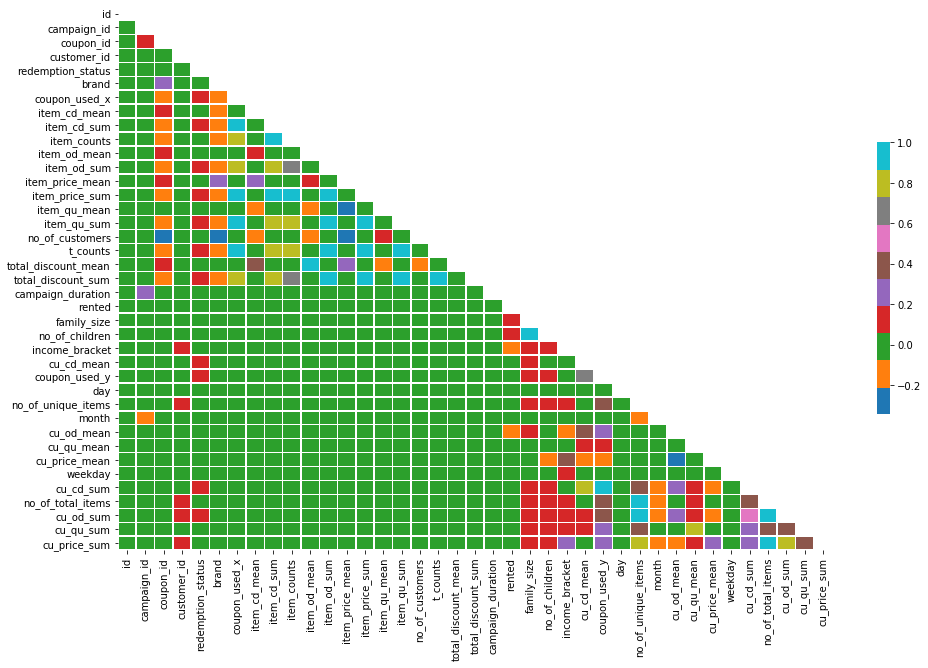

In [7]:
#Check correlation of the data
corr = train_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corr, mask=mask, linewidths=.5, cbar_kws={"shrink": .5}, cmap='tab10')
plt.show()

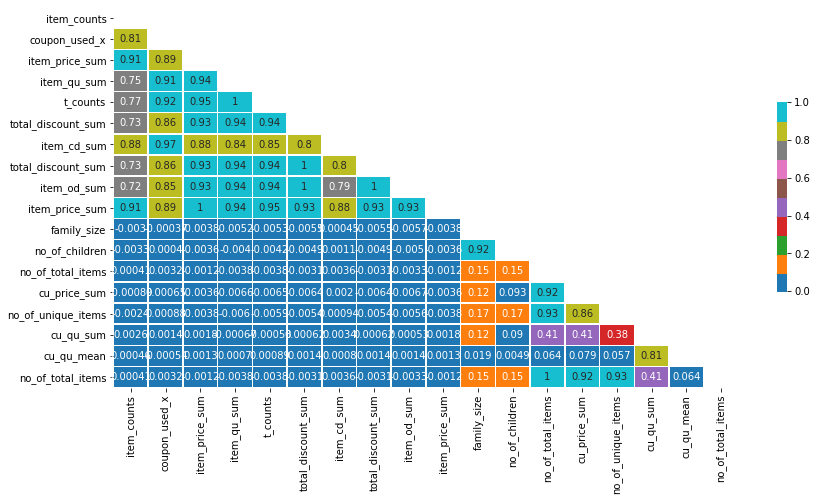

In [8]:
#Check the variable which has more correlation
corr1 = train_df[['item_counts', 'coupon_used_x', 'item_price_sum', 'item_qu_sum', 't_counts', 'total_discount_sum',
       'item_cd_sum', 'total_discount_sum', 'item_od_sum', 'item_price_sum', 'family_size', 'no_of_children',
      'no_of_total_items', 'cu_price_sum', 'no_of_unique_items', 'cu_qu_sum', 'cu_qu_mean', 'no_of_total_items']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr1, dtype=bool))
f, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(corr1, mask=mask, linewidths=.5, cbar_kws={"shrink": .5}, cmap='tab10', annot = True)
plt.show()

# Observations

   1. There are high positive correlation between (no_of_childeren and family size), (item_counts and coupon_used_x), etc
   2.

In [9]:
'''train_df.total_discount_sum=np.abs(train_df.total_discount_sum)
train_df.total_discount_mean=np.abs(train_df.total_discount_mean)
train_df.loc[train_df['total_discount_sum']>3000000]'''

"train_df.total_discount_sum=np.abs(train_df.total_discount_sum)\ntrain_df.total_discount_mean=np.abs(train_df.total_discount_mean)\ntrain_df.loc[train_df['total_discount_sum']>3000000]"

In [10]:
'''fig,[ax1,ax2]=plt.subplots(1,2,figsize=(15,5))
train_df['total_discount_sum'].plot(kind='box', ax=ax1)
train_df['total_discount_mean'].plot(kind='box', ax=ax2)


#start_date = date_redemption.set_index('start_date')
#start_date.sort_index(inplace=True)
#start_date.campaign_duration.plot()'''

"fig,[ax1,ax2]=plt.subplots(1,2,figsize=(15,5))\ntrain_df['total_discount_sum'].plot(kind='box', ax=ax1)\ntrain_df['total_discount_mean'].plot(kind='box', ax=ax2)\n\n\n#start_date = date_redemption.set_index('start_date')\n#start_date.sort_index(inplace=True)\n#start_date.campaign_duration.plot()"

campaign_type  redemption_status
X              0                    57048
               1                      636
Y              0                    20592
               1                       93
Name: redemption_status, dtype: int64
X_success : 1.103 %
X_fail : 98.897 %
Y_success : 0.45 %
Y_fail : 99.55 %
X_redeem count: 57684
Y_redeem count: 20685


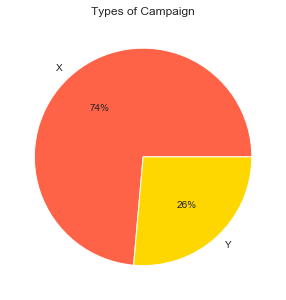

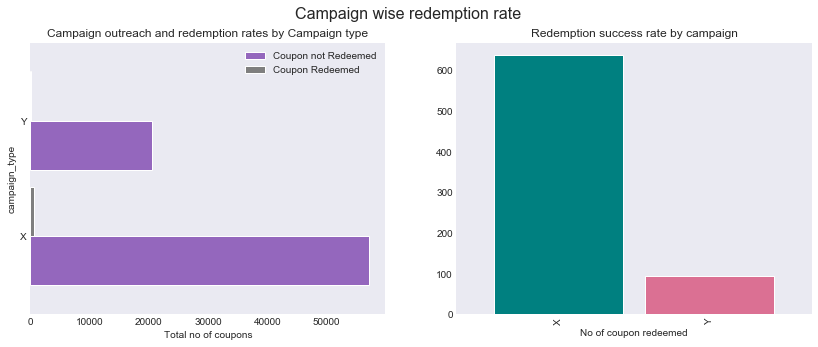

In [87]:
redeem = train_df.groupby('campaign_type').redemption_status.value_counts()
#Count of success and failure redemption rate by campaign 
print(redeem)
print('================================================================================')
X_redeem = redeem['X'][1] + redeem['X'][0]
Y_redeem = redeem['Y'][1] + redeem['Y'][0]
X_success = (redeem['X'][1]/X_redeem)*100
X_fail = (redeem['X'][0]/X_redeem)*100
Y_success = (redeem['Y'][1]/Y_redeem)*100
Y_fail = (redeem['Y'][0]/Y_redeem)*100
#Percentage of success and failure redemption status by campaign 
print('X_success :', round(X_success,3),'%')
print('X_fail :', round(X_fail,3),'%')
print('Y_success :', round(Y_success,3),'%')
print('Y_fail :', round(Y_fail,3),'%')
print('================================================================================')
#X_redeem_per = (X_redeem_count/len(train_df))*100
#Y_redeem_per = (Y_redeem_count/len(train_df))*100
print('X_redeem count:', X_redeem)
print('Y_redeem count:', Y_redeem)
#print('X_redeem percentage :', X_redeem_per)
#print('Y_redeem percentage:', Y_redeem_per)

print('================================================================================')

fig, ax= plt.subplots()
fig.set_size_inches(5,5)
train_df.groupby('campaign_type').size().plot(kind='pie',colors=['tomato', 'gold'], ax=ax, autopct='%1.0f%%', title='Types of Campaign')
#ax.axis('equal')
ax.set_ylabel('')

fig1,ax1 = plt.subplots(1,2, figsize=(14,5))
#plt.style.use('darkgrid')

redeem.unstack().plot(kind='barh', color=['#9467bd', '#7f7f7f'], zorder=2, width=0.85, ax=ax1[0])
ax1[0].set_title('Campaign outreach and redemption rates by Campaign type', fontsize=12)
ax1[0].set_xlabel('Total no of coupons')
ax1[0].legend(['Coupon not Redeemed', 'Coupon Redeemed'])

redeem.unstack()[1].plot(kind='bar', color=['teal', 'palevioletred'], zorder=2, width=0.85, ax=ax1[1])
ax1[1].set_title('Redemption success rate by campaign', fontsize=12)
ax1[1].set_xlabel('No of coupon redeemed')
fig1.suptitle('Campaign wise redemption rate', fontsize=16)
plt.show()

## Observations:
    1. Of the total record 74% of the campaign was done by Factor X while remaining 26% was by Y.
    2. From the campaign outreach we can see that campaign X redemption failure rate is 99% and Campaign Y failure rate is 99.6%. 
    3. This shows that coupon redemption for both the campaign happened just for 1% of the sample data. Since we have low successful rate on both campaign we cannot simply consider which campaign has performed better or which is the most succussful campaign.
    4. However we can use proportional test to justify which campaign has performed better.

In [12]:
#Proportional test to justify campaign X has performed better than campaign Y
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
# can we assume anything from our sample
significance = 0.025
# our samples - 82% are good in one, and ~79% are good in the other
# note - the samples do not need to be the same size
sample_success_a, sample_size_a = (redeem['X'][1], X_redeem)
sample_success_b, sample_size_b = (redeem['Y'][1], Y_redeem)
# check our sample against Ho for Ha != Ho
successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])
# note, no need for a Ho value here - it's derived from the other parameters
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > significance:
   print ("H0: Proportions from the two samples are same.")
else:
   print ("Ha: Proportions from the two samples are different.")

z_stat: 8.393, p_value: 0.000
Ha: Proportions from the two samples are different.


## Result:
From the above proportion test we proved that Campaign X has performed better than Campaign Y. The sample data results are generalizable to population.

In [13]:
train_df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'brand', 'brand_type', 'category', 'coupon_used_x', 'item_cd_mean',
       'item_cd_sum', 'item_counts', 'item_od_mean', 'item_od_sum',
       'item_price_mean', 'item_price_sum', 'item_qu_mean', 'item_qu_sum',
       'no_of_customers', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'start_date', 'end_date',
       'campaign_duration', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'cu_cd_mean',
       'coupon_used_y', 'day', 'no_of_unique_items', 'month', 'cu_od_mean',
       'cu_qu_mean', 'cu_price_mean', 'weekday', 'cu_cd_sum',
       'no_of_total_items', 'cu_od_sum', 'cu_qu_sum', 'cu_price_sum'],
      dtype='object')

In [14]:
date_redemption=train_df.copy()


avg_duration = np.mean(date_redemption.campaign_duration)
dur_X=date_redemption.campaign_duration[date_redemption['campaign_type']=='X']
dur_Y=date_redemption.campaign_duration[date_redemption['campaign_type']=='Y']
dur_X_suc = dur_X[date_redemption['redemption_status']==1]
dur_Y_suc = dur_Y[date_redemption['redemption_status']==1]


print('Average campaign duration:', avg_duration)
print('Average campaign duration of X campaign:', np.mean(dur_X))
print('Average campaign duration of Y campaign:', np.mean(dur_Y))
print('Average campaign duration of successful X campaign:', np.mean(dur_X_suc))
print('Average campaign duration of successful Y campaign:', np.mean(dur_Y_suc))

Average campaign duration: 44.77132539652158
Average campaign duration of X campaign: 46.54399833576035
Average campaign duration of Y campaign: 39.8278946096205
Average campaign duration of successful X campaign: 46.679245283018865
Average campaign duration of successful Y campaign: 37.96774193548387


## Result:
    X campaign has an average duration of 47 days while Y has an average duration of 38 days. 
    As a result more number of days of campaign will give more redemption rate.
    

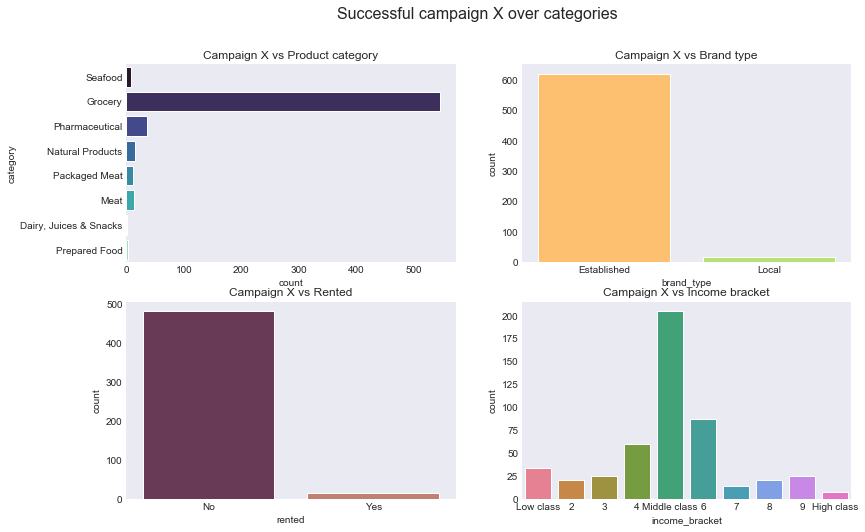

In [15]:
Suc_x_y = train_df[train_df['redemption_status']==1]
Suc_x = Suc_x_y[Suc_x_y['campaign_type']=='X']

sns.set_style("dark")
fig,[[ax,ax1],[ax2,ax3]]=plt.subplots(2,2,figsize=(13,8))
fig.suptitle('Successful campaign X over categories', fontsize=16)

sns.countplot(data=Suc_x, y='category', ax=ax, palette='mako', saturation=0.95)
ax.set_title('Campaign X vs Product category')

sns.countplot(data=Suc_x, x='brand_type', ax=ax1, palette='RdYlGn', saturation=0.99)
ax1.set_title('Campaign X vs Brand type')
#fig1,[ax2,ax3]=plt.subplots(1,2,figsize=(13,5), constrained_layout=True)

sns.countplot(data=Suc_x, x='rented', ax=ax2, palette='rocket', saturation=0.45)
ax2.set_xticklabels(['No', 'Yes']) 
ax2.set_title('Campaign X vs Rented')

#fig1,ax1=plt.subplots(figsize=(8,5))
sns.countplot(data=Suc_x, x='income_bracket', ax=ax3, palette='husl', saturation=0.75)
ax3.set_xticklabels(['Low class',2,3,4,'Middle class',6,7,8,9, 'High class']) 
ax3.set_title('Campaign X vs Income bracket')

#fig.suptitle('', fontsize=16)
#fig.tight_layout()

plt.show()

## Result: 
The above result shows that one class in each category gives majority support for campaign X to be successfull. 
     1. Groecery under the product category have the maximum count than the rest of the product category. This means that there are more chances to redeem coupon when the there is a Grocery products 
     2. People who have purchased a well know brand majorly supports campaign X.
     3. Pople who have not staying in rented house supports campaign X.
     4. Middle class people majorly supports campaing X 
     
     

In [16]:
discount_check = train_df.copy()
#print(len(discount_check[(discount_check.total_discount_mean==0) & (discount_check.total_discount_sum!=0)]))


tot_disc=len(discount_check[discount_check.total_discount_mean>0])
print('Total number of discount given : ', tot_disc)

#tot_red = len(discount_check[discount_check['redemption_status']==1])
#print('Total number of coupon redeemed : ', tot_red)


#Redeemed
red_dis = discount_check[discount_check['redemption_status']==1]
print("Total number of coupon redeemed : ",len(red_dis))
print('Discount given and redeemed :',len(red_dis[(red_dis.total_discount_mean>0)]))
print('Discount not given but redeemed :',len(red_dis[(red_dis.total_discount_mean==0)]))

#Suc_x_y['total_discount_mean']=np.abs(Suc_x_y['total_discount_mean'])
#Suc_x_y['total_discount_sum']=np.abs(Suc_x_y['total_discount_sum'])
#len(Suc_x_y[(Suc_x_y['total_discount_mean']==0) & Suc_x_y['redemption_status']==1])

Total number of discount given :  77040
Total number of coupon redeemed :  729
Discount given and redeemed : 729
Discount not given but redeemed : 0


## Result:
   This shows that coupon redemption has happened only when there is a discount given to the customers.

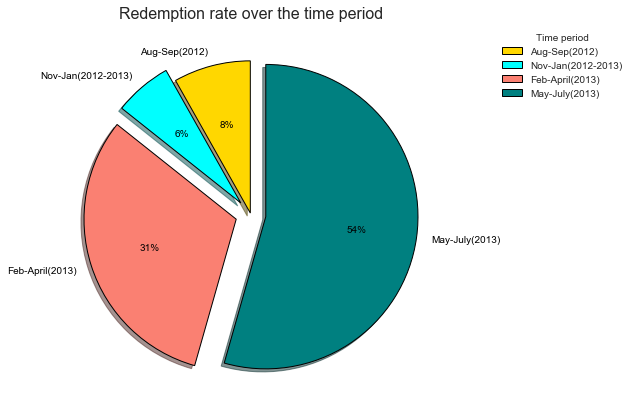

In [98]:
date_check=Suc_x.groupby(['start_date','end_date']).redemption_status.value_counts()
fig,ax = plt.subplots(figsize =(10, 7))  
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
lab=['Aug-Sep(2012)','Nov-Jan(2012-2013)','Feb-April(2013)','May-July(2013)']
colors = ( "gold", "cyan", "salmon","teal") 
explode = (0.01, 0.1, 0.1, 0.1)
date_check.plot(kind='pie',ax=ax, wedgeprops = wp,shadow = True,
                startangle = 90, textprops = dict(color ="black"),
                labels=lab, colors=colors,explode=explode,autopct='%1.0f%%')
ax.legend(title ="Time period", 
          loc ="upper right", 
          bbox_to_anchor =(1, 0, 0.5, 1))
ax.set_title("Redemption rate over the time period", fontsize=16) 
ax.set_axis_off() 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


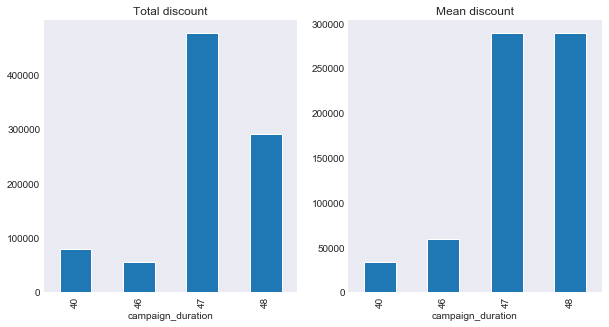

In [20]:
#Suc_x.groupby(['start_date','end_date','campaign_duration','item_qu_sum']).total_discount_sum.mean()
Suc_x['total_discount_mean']=np.abs(Suc_x['total_discount_mean'])
Suc_x['total_discount_sum']=np.abs(Suc_x['total_discount_sum'])
fig,[ax1,ax2]=plt.subplots(1,2, figsize=(10,5))
#fig.suptitle('Discount on each campaign duration')
#fig.tight_layout()
Suc_x.groupby(['campaign_duration']).no_of_total_items.sum().plot(kind='bar', ax=ax1)
ax1.set_title('Total discount')
Suc_x.groupby(['campaign_duration']).total_discount_sum.mean().plot(kind='bar', ax=ax2)
ax2.set_title('Mean discount')
plt.show()

In [21]:
train_df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'brand', 'brand_type', 'category', 'coupon_used_x', 'item_cd_mean',
       'item_cd_sum', 'item_counts', 'item_od_mean', 'item_od_sum',
       'item_price_mean', 'item_price_sum', 'item_qu_mean', 'item_qu_sum',
       'no_of_customers', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'start_date', 'end_date',
       'campaign_duration', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'cu_cd_mean',
       'coupon_used_y', 'day', 'no_of_unique_items', 'month', 'cu_od_mean',
       'cu_qu_mean', 'cu_price_mean', 'weekday', 'cu_cd_sum',
       'no_of_total_items', 'cu_od_sum', 'cu_qu_sum', 'cu_price_sum'],
      dtype='object')

In [23]:
#Aggregate each customer_id
customerId = pd.pivot_table(train_df, index = "customer_id", 
               values=['cu_cd_sum','coupon_used_y', 'no_of_unique_items','cu_od_sum','cu_price_sum','cu_qu_sum','redemption_status'],
               aggfunc={'coupon_used_y':np.sum,
                        'no_of_unique_items':np.sum,
                        'cu_od_sum': np.sum,
                        'cu_qu_sum':np.sum,
                        'cu_price_sum': np.sum,
                        'cu_cd_sum':np.sum,
                        'redemption_status':np.mean
                        }
              )
customerId.reset_index(inplace=True)
customerId['Total_discount'] = customerId.cu_od_sum + customerId.cu_qu_sum
customerId.head()

customer_id  coupon_used_y  cu_cd_sum     cu_od_sum  cu_price_sum  \
0            1           7332  198982.02  1.264651e+06  7.072709e+06   
1            3           2226   91540.68  4.167564e+05  1.685779e+06   
2            4             23    2048.15  4.495130e+04  6.096767e+05   
3            5            104    4723.16  4.637605e+05  3.828524e+06   
4            6            352   13107.84  1.926120e+05  1.513866e+06   

   cu_qu_sum  no_of_unique_items  redemption_status  Total_discount  
0     115338               43522           0.021277    1.379989e+06  
1     342846               17052           0.000000    7.596024e+05  
2       6440                2875           0.000000    5.139130e+04  
3    4854356               25480           0.000000    5.318117e+06  
4      22624               13728           0.000000    2.152360e+05

In [24]:
#Checking Avg discount 
coupon_not_used = customerId[customerId.coupon_used_y==0]
coupon_used = customerId[customerId.coupon_used_y>0]
used_mean = coupon_used['Total_discount'].mean()
not_used_mean = coupon_not_used['Total_discount'].mean()
print('Total number of Customers : ', len(customerId.customer_id))
print('Number of customers not used coupon at all : ', len(coupon_not_used))
print('Average Discount given to all the customers those not redeemd coupon: ', round(not_used_mean,0))
print('Average Discount given to all the customers those redeemd coupon: ', round(used_mean,0))

Total number of Customers :  1428
Number of customers not used coupon at all :  290
Average Discount given to all the customers those not redeemd coupon:  3240472.0
Average Discount given to all the customers those redeemd coupon:  9869412.0


### Result: 
Whenever there are more discount, people are more likely to redeem the coupon

In [25]:
len(customerId[customerId.redemption_status==1])

0

In [26]:
len(train_df.customer_id.unique())

1428

In [27]:
#1. Why X is better than y, 2. on which factor helps X to be sucessfull, 3. result
    #discount
    #Demogrphics
    #time dependency

    
#1. Why there is only 1% of coupon redeemed, 2. on which factor they have redeemed coupon, 3. What are the areas they need to imporove, 4. result  


#what is coupon used?


In [28]:
#Since campaign_id is not having more unique I don't think it'll affect our model. Hence am consider to keep it
train_df = train_df.drop(['id','coupon_id', 'customer_id'], axis=1)
test_df = test_df.drop(['id','coupon_id', 'customer_id'], axis=1)

# 5. Lable Encoding

In [29]:
#Mapping
age_map= {'18-25':0, '26-35':3, '36-45':4, '46-55':5, '56-70':2, '70+':1}
marital_map = {'Married':1, 'Single':0}
#Train encoding
train_df['brand_type']=LabelEncoder().fit_transform(train_df['brand_type'])
train_df['category']=LabelEncoder().fit_transform(train_df['category'])
train_df['campaign_type']=LabelEncoder().fit_transform(train_df['campaign_type'])
train_df=train_df.drop(['start_date','end_date'],axis=1)
train_df['age_range']=train_df['age_range'].map(age_map)
train_df['marital_status']=train_df['marital_status'].map(marital_map)

In [30]:
#Test encoding
test_df['brand_type']=LabelEncoder().fit_transform(test_df['brand_type'])
test_df['category']=LabelEncoder().fit_transform(test_df['category'])
test_df['campaign_type']=LabelEncoder().fit_transform(test_df['campaign_type'])
test_df=test_df.drop(['start_date','end_date'],axis=1)
test_df['age_range']=test_df['age_range'].map(age_map)
test_df['marital_status']=test_df['marital_status'].map(marital_map)

# 6. Missing Values Imputation

Missing values:
 age_range         34708
marital_status    34708
rented            34708
family_size       34708
no_of_children    34708
income_bracket    34708
cu_price_sum          0
dtype: int64


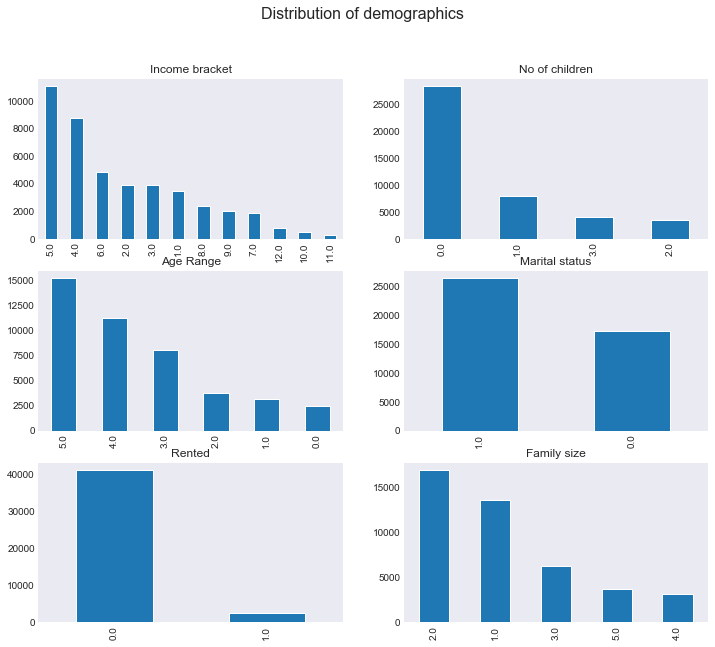

In [31]:

def missing_col_dist(data):
    print("Missing values:\n",train_df.isnull().sum().sort_values(ascending=False)[0:7])
    fig, [[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2, figsize=(12,10))
    fig.suptitle('Distribution of demographics', fontsize=16)
    data.income_bracket.value_counts().plot(kind='bar',ax=ax1, title='Income bracket')
    data.no_of_children.value_counts().plot(kind='bar',ax=ax2, title='No of children')
    data.age_range.value_counts().plot(kind='bar',ax=ax3, title='Age Range')
    data.marital_status.value_counts().plot(kind='bar',ax=ax4, title='Marital status')
    data.rented.value_counts().plot(kind='bar',ax=ax5, title='Rented')
    data.family_size.value_counts().plot(kind='bar',ax=ax6, title='Family size')
    #fig.tight_layout()
    
missing_col_dist(train_df)

In [32]:
DT = DecisionTreeClassifier()
def predict_miss_val(data, model):
    #from sklearn.naive_bayes import GaussianNB
    #from sklearn.ensemble import RandomForestClassifier
    #from sklearn.tree import DecisionTreeClassifier
    #from sklearn.neighbors import KNeighborsClassifier
    #mod_map = {'NB':GaussianNB, 'RF': RandomForestClassifier, 'DT': DecisionTreeClassifier, 'KNN': KNeighborsClassifier}
    #model1= model.map(mod_map)
    
    data_copy = data.copy()
    miss_cols = [col for col in data.columns if data[col].isnull().any()]
    miss_cols = data[miss_cols]
    non_miss_cols =  data.drop(miss_cols, axis=1)
    for i in miss_cols:
        miss_train_y = miss_cols[i][miss_cols[i].notnull()] 
        miss_train_x = non_miss_cols[miss_cols[i].notnull()]
        miss_test_x = non_miss_cols[miss_cols[i].isnull()]
        model.fit(miss_train_x,miss_train_y)
        miss_pred = model.predict(miss_test_x)
        
        data_copy[i][data_copy[i].isnull()] = miss_pred
        out=data_copy[i]
        
        final_out = pd.concat([data_copy,out],axis=1)
        #print(final_out.isnull().sum())
    return final_out
final_df = predict_miss_val(train_df,DT)
train_df=final_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A valu

Missing values:
 cu_price_sum           0
campaign_type          0
total_discount_mean    0
t_counts               0
no_of_customers        0
item_qu_sum            0
item_qu_mean           0
dtype: int64


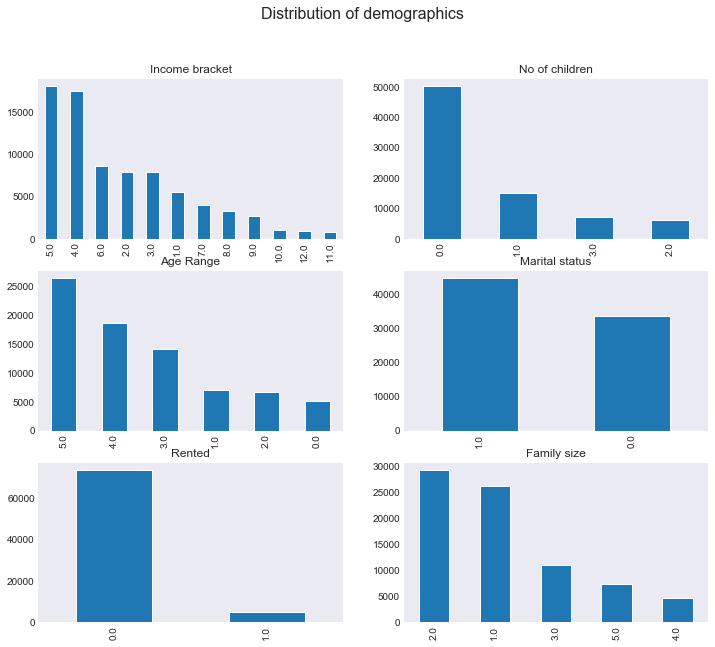

In [33]:
final_df = final_df.loc[:,~final_df.columns.duplicated()]
train_df = final_df
missing_col_dist(train_df)

# 7. Class Balance

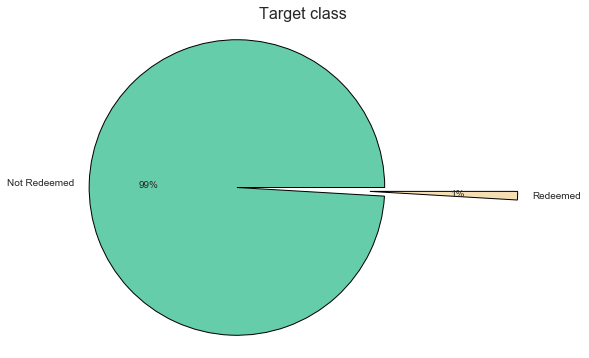

In [155]:
fig1, ax1 = plt.subplots(figsize=(10,6))
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
train_df.redemption_status.value_counts().plot(kind='pie',explode=(0.9,0.0), autopct='%1.0f%%', ax=ax1, colors=["mediumaquamarine", "wheat"], labels=['Not Redeemed','Redeemed'],wedgeprops = wp)#print(y.value_counts())
ax1.set_title("Target class", fontsize=16)
ax1.axis('equal')
ax1.set_axis_off() 

In [121]:
train_df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'brand', 'brand_type', 'category', 'coupon_used_x', 'item_cd_mean',
       'item_cd_sum', 'item_counts', 'item_od_mean', 'item_od_sum',
       'item_price_mean', 'item_price_sum', 'item_qu_mean', 'item_qu_sum',
       'no_of_customers', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'start_date', 'end_date',
       'campaign_duration', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'cu_cd_mean',
       'coupon_used_y', 'day', 'no_of_unique_items', 'month', 'cu_od_mean',
       'cu_qu_mean', 'cu_price_mean', 'weekday', 'cu_cd_sum',
       'no_of_total_items', 'cu_od_sum', 'cu_qu_sum', 'cu_price_sum'],
      dtype='object')

In [122]:
#X=train_df.drop(['redemption_status','campaign_id','brand','month','day','weekday'], axis=1)
X=train_df.drop(['redemption_status'], axis=1)
y=train_df['redemption_status']
#x_test = test_df

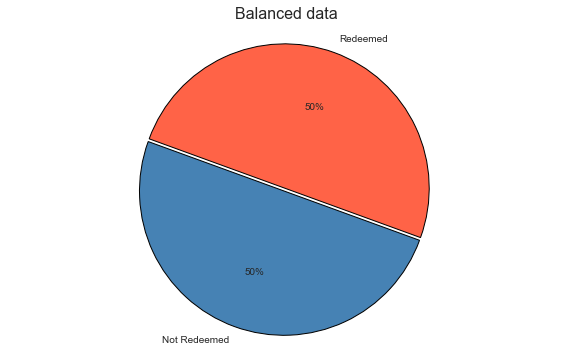

In [156]:
#We can see our data is completely imbalanced. If we build classification model then our prediction would be biased. Hence we can use RandomOverSampler or SMOTE to make our data balanced
from imblearn.over_sampling import RandomOverSampler
split = RandomOverSampler()
x_train_sample, y_train_sample = split.fit_sample(X,y)
fig1, ax1 = plt.subplots(figsize=(10,6))
y_train_sample.value_counts().plot(kind='pie',autopct='%1.0f%%', explode=(0.01,0.01),startangle=160,
                                   ax=ax1, colors=["steelblue", "tomato"], labels=['Not Redeemed','Redeemed'], wedgeprops = { 'linewidth' : 1, 'edgecolor' : "black" })
ax1.axis('equal')
ax1.set_title('Balanced data', fontsize=16)
ax1.set_axis_off() 

In [124]:
print('x_train_sample: ' ,x_train_sample.shape,'\n')
print('y_train_sample: ', y_train_sample.shape,'\n')
#print('x_test: ', x_test.shape)

x_train_sample:  (155280, 45) 

y_train_sample:  (155280,) 



In [125]:
'''print(train_df.columns)
len(train_df.marital_status.value_counts())'''

'print(train_df.columns)\nlen(train_df.marital_status.value_counts())'

In [40]:
'''len(x_train_sample.marital_status.value_counts())'''

'len(x_train_sample.marital_status.value_counts())'

# 8. Feature scaling -Normalization

In [41]:
#Feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_sample)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train_sample.columns)
x_train_scaled.head()

campaign_id     brand  brand_type  category  coupon_used_x  item_cd_mean  \
0     0.413793  0.204672         0.0       0.3       0.071778      0.017430   
1     0.413793  0.010197         1.0       0.3       0.000000      0.000000   
2     0.275862  0.103634         0.0       0.7       0.005637      0.041933   
3     0.413793  0.113089         0.0       0.3       0.000376      0.062500   
4     0.241379  0.288654         0.0       0.3       0.008643      0.002780   

   item_cd_sum  item_counts  item_od_mean  item_od_sum  ...     month  \
0     0.047083     0.010498      0.092144     0.054437  ...  0.363636   
1     0.000000     0.000169      0.021198     0.000180  ...  0.454545   
2     0.005329     0.005588      0.159434     0.003827  ...  0.181818   
3     0.000157     0.000254      0.009246     0.000080  ...  0.636364   
4     0.005016     0.002624      0.063687     0.014356  ...  0.363636   

   cu_od_mean  cu_qu_mean  cu_price_mean   weekday  cu_cd_sum  \
0    0.530269    0.097290       0.527448  0.333333   0.007459   
1    0.391359    0.008741       0.736467  0.833333   0.103687   
2    0.213268    0.000100       0.372891  0.333333   0.179742   
3    0.213455    0.000071       0.307602  0.666667   0.014919   
4    0.198074    0.070622       0.222109  0.666667   0.022199   

   no_of_total_items  cu_od_sum  cu_qu_sum  cu_price_sum  
0           0.051138   0.108080   0.040292      0.082821  
1           0.068033   0.104693   0.004606      0.142392  
2           0.199820   0.176515   0.000483      0.213393  
3           0.034692   0.034815   0.000083      0.036869  
4           0.107907   0.092485   0.053095      0.080213  

[5 rows x 40 columns]

# 9. Data split - Train test split

In [42]:
# Splitting our data using train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_scaled, y_train_sample, test_size=0.3, random_state=0)

# 10. Model Building and Data validation

In [43]:
#Model using Naive Bayes
NB = GaussianNB()
NB_fit = NB.fit(x_train, y_train)
y_pred_NB = NB_fit.predict(x_test)
print('NB_score :', accuracy_score(y_test,y_pred_NB))

NB_Accuracy = cross_val_score(NB,x_train_sample,y_train_sample,cv=10, scoring='accuracy')
print('NB_Accuracy :', NB_Accuracy)
print('NB_Accuracy_Mean :', NB_Accuracy.mean())

NB_score : 0.6445346041559333
NB_Accuracy : [0.60722566 0.61553323 0.60703246 0.60819165 0.61192684 0.60671046
 0.61321484 0.60909325 0.60600206 0.61102524]
NB_Accuracy_Mean : 0.6095955692941782


In [44]:
y_pred_NB_prob = NB_fit.predict_proba(x_test)[:,1]
y_pred_NB_prob

array([0.04804347, 0.05958821, 0.00041008, ..., 0.30057216, 0.00345945,
       0.01857429])

In [54]:
#Model using Logistic regression
LG = LogisticRegression(max_iter=10000)
LG_fit = LG.fit(x_train, y_train)
y_pred_LG = LG_fit.predict(x_test)
print('LG_score :', accuracy_score(y_test,y_pred_LG))

LG_Accuracy = cross_val_score(LG,x_train_sample,y_train_sample,cv=10, scoring='accuracy')
print('LG_Accuracy :', LG_Accuracy)
print('LG_Accuracy_Mean :', LG_Accuracy.mean())

LG_score : 0.8095483427786364
LG_Accuracy : [0.76043277 0.76835394 0.76294436 0.76803194 0.76758114 0.76107676
 0.77015714 0.77202473 0.75663318 0.76655075]
LG_Accuracy_Mean : 0.7653786707882534


In [55]:
'''param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [8000, 9000, 10000]
    }
]'''
param_grid = [    
    {
    'max_iter' : [6000, 8000, 10000]
    }
]

In [56]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(LG, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [57]:
best_clf = clf.fit(x_train, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 32.5min finished


In [58]:
best_clf.best_estimator_

LogisticRegression(C=3792.690190732246, max_iter=10000)

In [53]:
print (f'Accuracy - : {best_clf.score(X,y):.3f}')


Accuracy - : 0.009


In [47]:
y_pred_LG_prob = LG_fit.predict_proba(x_test)[:,1]
y_pred_LG_prob

array([0.75352539, 0.61412013, 0.96808917, ..., 0.92465061, 0.96495971,
       0.70810733])

In [48]:
#Model using DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT_fit = DT.fit(x_train, y_train)
y_pred_DT = DT_fit.predict(x_test)
print('DT_score :', accuracy_score(y_test,y_pred_DT))

DT_Accuracy = cross_val_score(DT,x_train_sample,y_train_sample,cv=10, scoring='accuracy')
print('RF_Accuracy :', DT_Accuracy)
print('RF_Accuracy_Mean :', DT_Accuracy.mean())

DT_score : 0.9959428129829985
RF_Accuracy : [0.99742401 0.99581401 0.99697321 0.99491242 0.99626481 0.99613601
 0.99542761 0.99613601 0.99665121 0.99613601]
RF_Accuracy_Mean : 0.9961875321998969


In [72]:
y_pred_DT_prob = DT_fit.predict_proba(x_test)[:,1]
y_pred_DT_prob

array([1., 1., 1., ..., 1., 1., 1.])

In [49]:
#Model using RandomForestClassifier
RF = RandomForestClassifier()
RF_fit = RF.fit(x_train, y_train)
y_pred_RF = RF_fit.predict(x_test)
print('Random Forest score :', round(accuracy_score(y_test,y_pred_RF),2)*100,"%")
RF_Accuracy = cross_val_score(RF,x_train_sample,y_train_sample,cv=10, scoring='accuracy')
print('RF_Accuracy :', RF_Accuracy)
print('RF_Accuracy_Mean :', RF_Accuracy.mean())

Random Forest score : 100.0 %
RF_Accuracy : [0.9992272 0.9988408 0.9992272 0.9987764 0.998712  0.998712  0.9990984
 0.9992916 0.9992272 0.9990984]
RF_Accuracy_Mean : 0.9990211231324059


In [51]:
#Model using KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=3)
KNN_fit = KNN.fit(x_train, y_train)
y_pred_KNN = KNN_fit.predict(x_test)
print('KNN_score :', accuracy_score(y_test,y_pred_KNN))

KNN_Accuracy = cross_val_score(KNN,x_train_sample,y_train_sample,cv=10, scoring='accuracy')
print('KNN_Accuracy :', KNN_Accuracy)
print('KNN_Accuracy_Mean :', KNN_Accuracy.mean())

KNN_score : 0.9900824317362185
KNN_Accuracy : [0.99188563 0.99059763 0.99143483 0.99124163 0.99175683 0.99169243
 0.99214323 0.99130603 0.99072643 0.99130603]
KNN_Accuracy_Mean : 0.991409067490984


In [52]:
#Importance of each features under Decision Tree
Importance_Feature = pd.DataFrame({
        'Feature' : x_train.columns, 
        'Importance' : np.round(RF_fit.feature_importances_,3)
            })
Importance_Feature.sort_values(by='Importance', ascending=False)

Feature  Importance
27        coupon_used_y       0.127
35            cu_cd_sum       0.112
4         coupon_used_x       0.081
26           cu_cd_mean       0.081
6           item_cd_sum       0.067
5          item_cd_mean       0.052
17   total_discount_sum       0.041
11       item_price_sum       0.030
15             t_counts       0.028
14      no_of_customers       0.022
36    no_of_total_items       0.022
37            cu_od_sum       0.021
13          item_qu_sum       0.021
29   no_of_unique_items       0.018
39         cu_price_sum       0.018
9           item_od_sum       0.017
7           item_counts       0.017
38            cu_qu_sum       0.017
31           cu_od_mean       0.016
33        cu_price_mean       0.016
32           cu_qu_mean       0.015
1                 brand       0.013
28                  day       0.013
30                month       0.012
18        campaign_type       0.011
19    campaign_duration       0.011
25       income_bracket       0.011
16  total_discount_mean       0.010
12         item_qu_mean       0.010
10      item_price_mean       0.010
8          item_od_mean       0.010
0           campaign_id       0.009
34              weekday       0.008
3              category       0.006
2            brand_type       0.006
20            age_range       0.006
23          family_size       0.005
24       no_of_children       0.004
22               rented       0.001
21       marital_status       0.001

# 11. Model performance score

In [146]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

def report(actual, predicted, Models):
    print('**********************',Models,'***********************')
    CM = confusion_matrix(actual, predicted)
    CM=pd.DataFrame(CM)
    
    #crosstab = pd.crosstab(actual, predicted, rownames = ['Actual'], colnames =['Predicted'], margins = True)
    print('Confusion Matrix\n',CM)
    Pre_score = precision_score(actual, predicted)
    print('Precision Score: ', Pre_score)
    Rec_score = recall_score(actual, predicted)
    print('Recall Score: ', Rec_score,'\n')    
    return ''

In [147]:
Y_pred_with_models = [y_pred_NB, y_pred_LG, y_pred_DT, y_pred_RF, y_pred_KNN]
Models = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN']
for i in range(len(Y_pred_with_models)):
    print(report(y_test, Y_pred_with_models[i], Models[i]))

********************** Naive Bayes ***********************
Confusion Matrix
        0     1
0  21938  1071
1  15472  8103
Precision Score:  0.8832570307390452
Recall Score:  0.343711558854719 


********************** Logistic Regression ***********************
Confusion Matrix
        0      1
0  18769   4240
1   4616  18959
Precision Score:  0.8172335014440277
Recall Score:  0.8041993637327678 


********************** Decision Tree ***********************
Confusion Matrix
        0      1
0  22820    189
1      0  23575
Precision Score:  0.992046793469113
Recall Score:  1.0 


********************** Random Forest ***********************
Confusion Matrix
        0      1
0  22948     61
1      0  23575
Precision Score:  0.997419191064478
Recall Score:  1.0 


********************** KNN ***********************
Confusion Matrix
        0      1
0  22547    462
1      0  23575
Precision Score:  0.9807796314015892
Recall Score:  1.0 




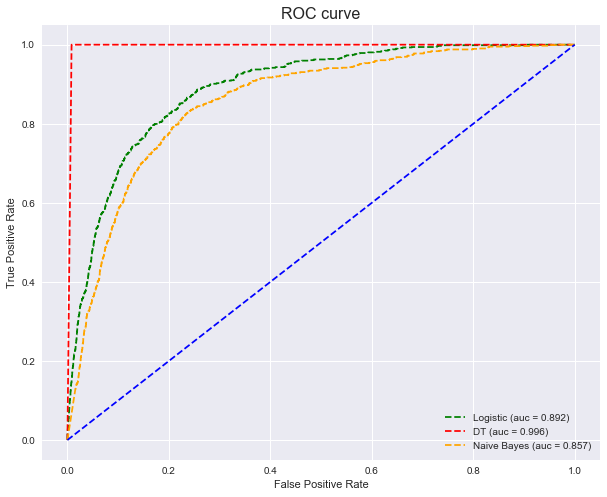

In [148]:
#AUC Score
lr_auc = roc_auc_score(y_test, y_pred_LG_prob)
DT_auc = roc_auc_score(y_test, y_pred_DT_prob)
NB_auc = roc_auc_score(y_test, y_pred_NB_prob)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_LG_prob)
DT_fpr, DT_tpr, _ = roc_curve(y_test, y_pred_DT_prob)
NB_fpr, NB_tpr, _ = roc_curve(y_test, y_pred_NB_prob)

plt.style.use('seaborn')
plt.figure(figsize=(10,8))
plt.plot(lr_fpr, lr_tpr, linestyle='--', color='green', label='Logistic (auc = %0.3f)' % lr_auc)
plt.plot(DT_fpr, DT_tpr, linestyle='--', color='red', label='DT (auc = %0.3f)' % DT_auc)
plt.plot(NB_fpr, NB_tpr, linestyle='--', color='orange', label='Naive Bayes (auc = %0.3f)' % NB_auc)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve', fontsize=16)
# show the legend
plt.legend()
# show the plot
plt.show()